-------------
### ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------------
### 辞書作成

実験設定

In [2]:
TARGET = "visit"
SAMPLE_SIZE = 10000

if TARGET == "GMV":
    X_LIM_VAR = 30000
    X_LIM_REDUC = 30
if TARGET == "BCR":
    X_LIM_VAR = 0.0003
    X_LIM_REDUC = 30
if TARGET == "PM":
    X_LIM_VAR = 50
    X_LIM_REDUC = 20
if TARGET == "visit":
    X_LIM_VAR = 0.00003
    X_LIM_REDUC = 100

各ファイルからコピペ

In [3]:
var_random_train = 2.2323050927100003e-05
var_random_test = 2.2323050927100003e-05

var_sep_dict_train = {
    "Kmeans": {
        "Proportional": 9.45599071344129e-06,
        "Post": 9.579342215458305e-06,
        "Optimal": 8.12286884448898e-06,
    },
    "Lasso-Kmeans": {
        "Proportional": 8.69604279771183e-06,
        "Post": 8.873467603694448e-06,
        "Optimal": 7.5854134640177665e-06,
    },
    "SFS-Kmeans-F": {
        "Proportional": 2.0425861044509342e-05,
        "Post": 2.0388044576028593e-05,
        "Optimal": 2.0182392480738536e-05,
    },
    "SFS-Kmeans-T": {
        "Proportional": 7.150808499113728e-06,
        "Post": 6.894715778805627e-06,
        "Optimal": 5.676688116551747e-06,
    },
}
var_sep_dict_test = {
    "Kmeans": {
        "Proportional": 9.556488339051139e-06,
        "Post": 9.631807070413802e-06,
        "Optimal": 8.17919594722635e-06,
    },
    "Lasso-Kmeans": {
        "Proportional": 8.96974704399997e-06,
        "Post": 9.016446455541878e-06,
        "Optimal": 8.007065263508818e-06,
    },
    "SFS-Kmeans-F": {
        "Proportional": 2.0764748809333766e-05,
        "Post": 2.038016062539414e-05,
        "Optimal": 2.0777930947107154e-05,
    },
    "SFS-Kmeans-T": {
        "Proportional": 7.22349879861241e-06,
        "Post": 7.1448925575830695e-06,
        "Optimal": 5.84146187215988e-06,
    },
}

var_once_dict_train = {
    "Proportional": 7.204075127369711e-06,
    "Post": 7.192772066177994e-06,
    "Optimal": 5.627768495493831e-06,
}
var_once_dict_test = {
    "Proportional": 7.264827773799833e-06,
    "Post": 7.43291016728963e-06,
    "Optimal": 5.876911851844305e-06,
}

var_cuped_train = 9.583715513108623e-06
var_cuped_test = 9.764286862229105e-06

var_coss_train = 1.43423725279e-05
var_coss_test = 1.4253979823900002e-05


分散削減率の計算

In [4]:
reduc_sep_dict_train = {}
reduc_sep_dict_test = {}
for method, d in var_sep_dict_train.items():
    reduc_sep_dict_train[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_train[method][allo] = (1 - var / var_random_train) * 100
for method, d in var_sep_dict_test.items():
    reduc_sep_dict_test[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_test[method][allo] = (1 - var / var_random_test) * 100

reduc_once_dict_train = {}
reduc_once_dict_test = {}
for allo, var in var_once_dict_train.items():
    reduc_once_dict_train[allo] = (1 - var / var_random_train) * 100
for allo, var in var_once_dict_test.items():
    reduc_once_dict_test[allo] = (1 - var / var_random_test) * 100

reduc_cuped_train = (1 - var_cuped_train / var_random_train) * 100
reduc_cuped_test = (1 - var_cuped_test / var_random_test) * 100

reduc_coss_train = (1 - var_coss_train / var_random_train) * 100
reduc_coss_test = (1 - var_coss_test / var_random_test) * 100

In [5]:
def make_var_dict(
    var_random: float,
    var_cuped: float,
    var_coss: float,
    var_sep_dict: dict[str, dict[str, float]],
    var_once_dict: dict[str, float],
) -> dict:
    var_dict = {"Random": var_random, "CUPED": var_cuped, "COSS": var_coss}
    for method, _ in var_sep_dict.items():
        var_dict[method] = {
            "Optimal": var_sep_dict[method]["Optimal"],
            "Post": var_sep_dict[method]["Post"],
            "Proportional": var_sep_dict[method]["Proportional"],
        }
    var_dict["SFS-Kmeans-Var"] = {
        "Optimal": var_once_dict["Optimal"],
        "Post": var_once_dict["Post"],
        "Proportional": var_once_dict["Proportional"],
    }

    return var_dict


def make_reduc_dict(
    reduc_cuped: float,
    reduc_coss: float,
    reduc_sep_dict: dict[str, dict[str, float]],
    reduc_once_dict: dict[str, float],
) -> dict:
    reduc_dict = {"CUPED": reduc_cuped, "COSS": reduc_coss}
    for method, _ in reduc_sep_dict.items():
        reduc_dict[method] = {
            "Optimal": reduc_sep_dict[method]["Optimal"],
            "Post": reduc_sep_dict[method]["Post"],
            "Proportional": reduc_sep_dict[method]["Proportional"],
        }
    reduc_dict["SFS-Kmeans-Var"] = {
        "Optimal": reduc_once_dict["Optimal"],
        "Post": reduc_once_dict["Post"],
        "Proportional": reduc_once_dict["Proportional"],
    }

    return reduc_dict

In [6]:
var_dict_train = make_var_dict(
    var_random=var_random_train,
    var_cuped=var_cuped_train,
    var_coss=var_coss_train,
    var_sep_dict=var_sep_dict_train,
    var_once_dict=var_once_dict_train,
)
var_dict_test = make_var_dict(
    var_random=var_random_test,
    var_cuped=var_cuped_test,
    var_coss=var_coss_train,
    var_sep_dict=var_sep_dict_test,
    var_once_dict=var_once_dict_test,
)

reduc_dict_train = make_reduc_dict(
    reduc_cuped=reduc_cuped_train,
    reduc_coss=reduc_coss_train,
    reduc_sep_dict=reduc_sep_dict_train,
    reduc_once_dict=reduc_once_dict_train,
)
reduc_dict_test = make_reduc_dict(
    reduc_cuped=reduc_cuped_test,
    reduc_coss=reduc_coss_test,
    reduc_sep_dict=reduc_sep_dict_test,
    reduc_once_dict=reduc_once_dict_test,
)

-----------
### 可視化

分散

訓練データの結果


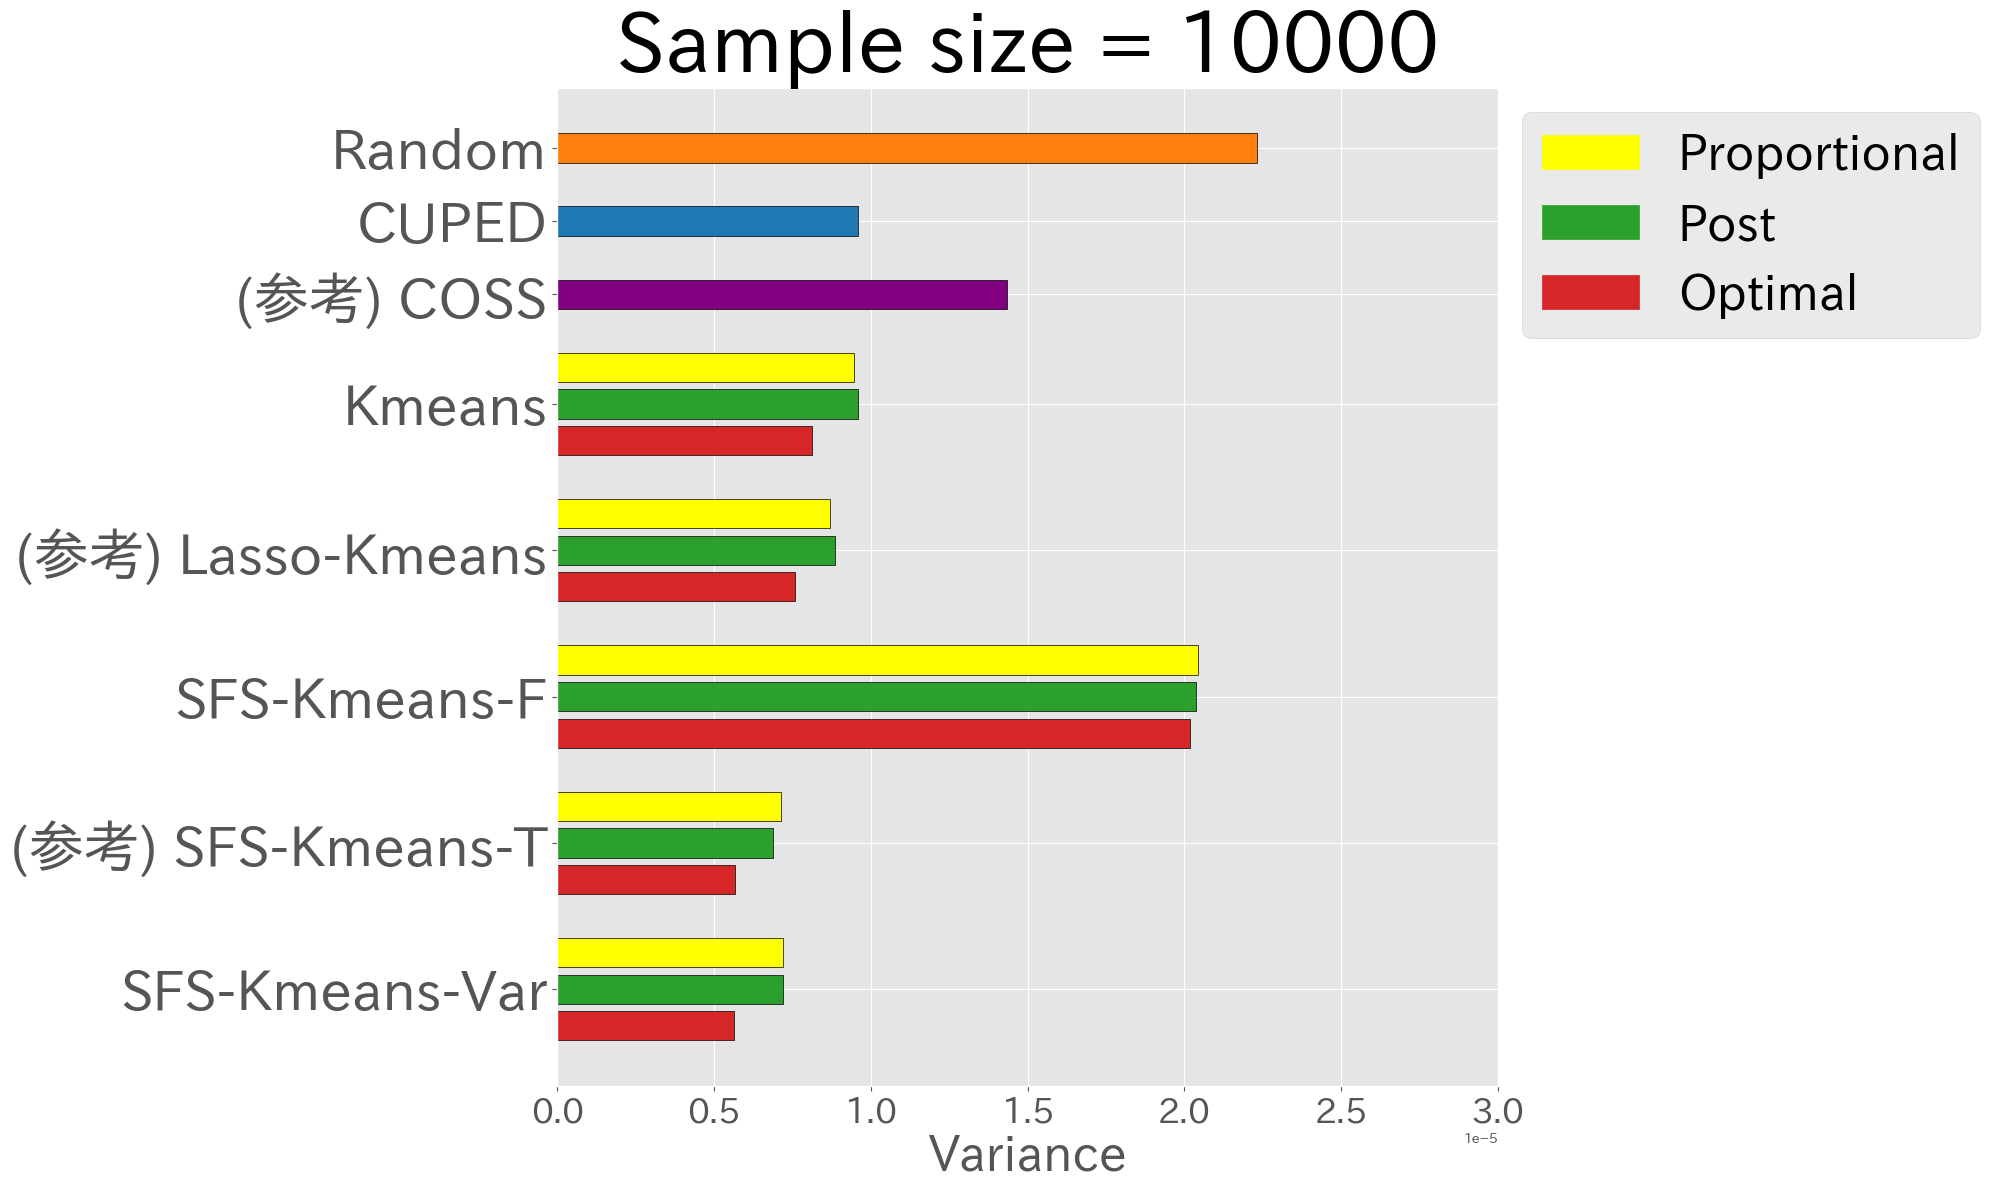

テストデータの結果


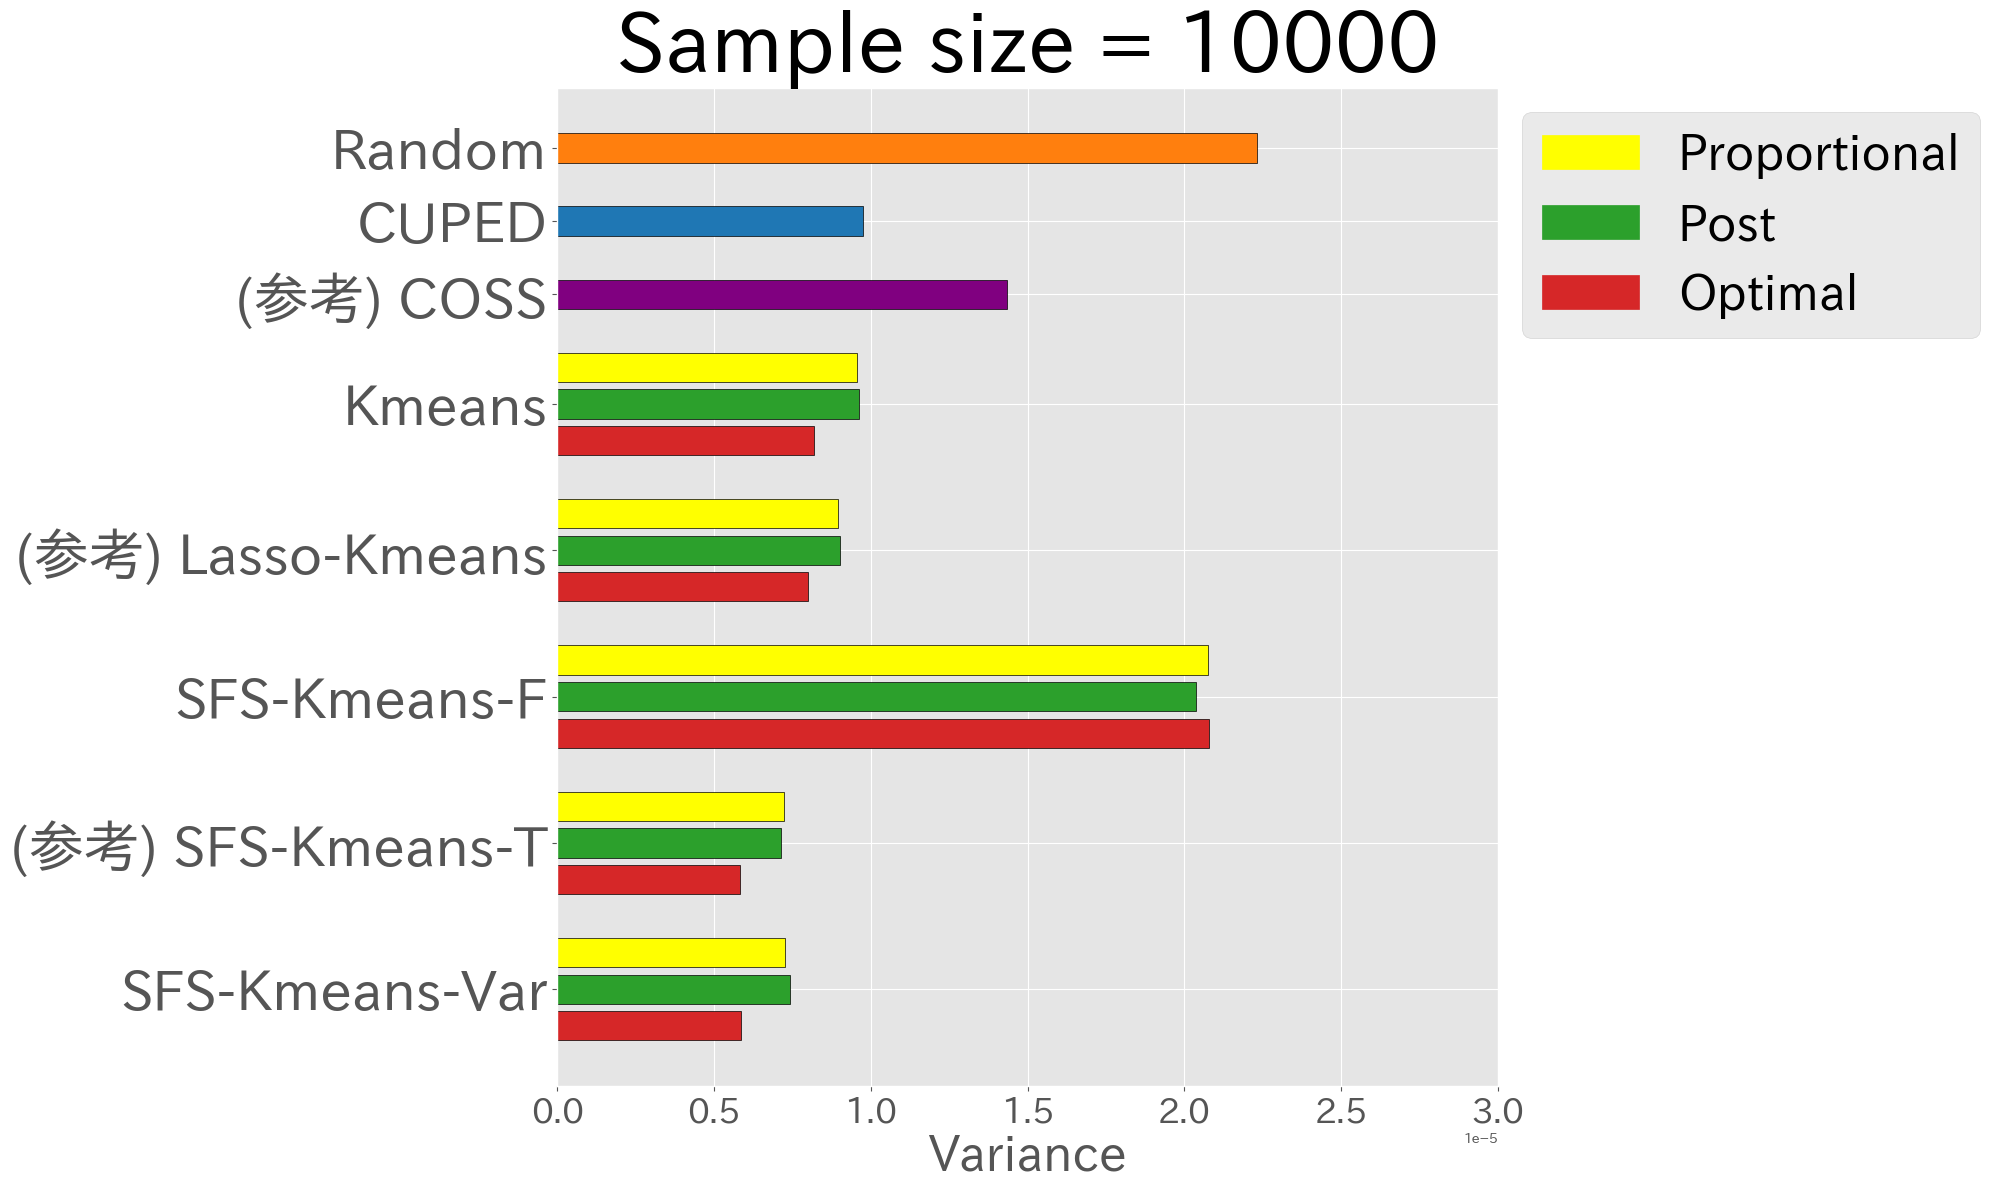

In [7]:
for var_dict in [var_dict_train, var_dict_test]:
    if var_dict == var_dict_train:
        print("訓練データの結果")
    if var_dict == var_dict_test:
        print("テストデータの結果")
    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-Var",
        "(参考) SFS-Kmeans-T",
        "SFS-Kmeans-F",
        "(参考) Lasso-Kmeans",
        "Kmeans",
        "(参考) COSS",
        "CUPED",
        "Random",
    ]

    values = (
        list(var_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(var_dict["SFS-Kmeans-T"].values())
        + [0]
        + list(var_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(var_dict["Lasso-Kmeans"].values())
        + [0]
        + list(var_dict["Kmeans"].values())
        + [0]
        + [var_dict["COSS"]]
        + [0]
        + [var_dict["CUPED"]]
        + [0]
        + [var_dict["Random"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#800080"]
        + ["#FFFFFF00"]
        + ["#1f77b4"]
        + ["#FFFFFF00"]
        + ["#ff7f0e"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [1, 5, 9, 13, 17, 20, 22, 24]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Post", "Optimal"]
    # 色のリスト
    legend_colors = ["#FFFF00", "#2ca02c", "#d62728"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance", fontsize=35)
    ax.set_title(f"Sample size = {SAMPLE_SIZE}", fontsize=60)
    ax.set_xlim(0, X_LIM_VAR)
    plt.tight_layout()
    plt.show()

削減率

訓練データの結果


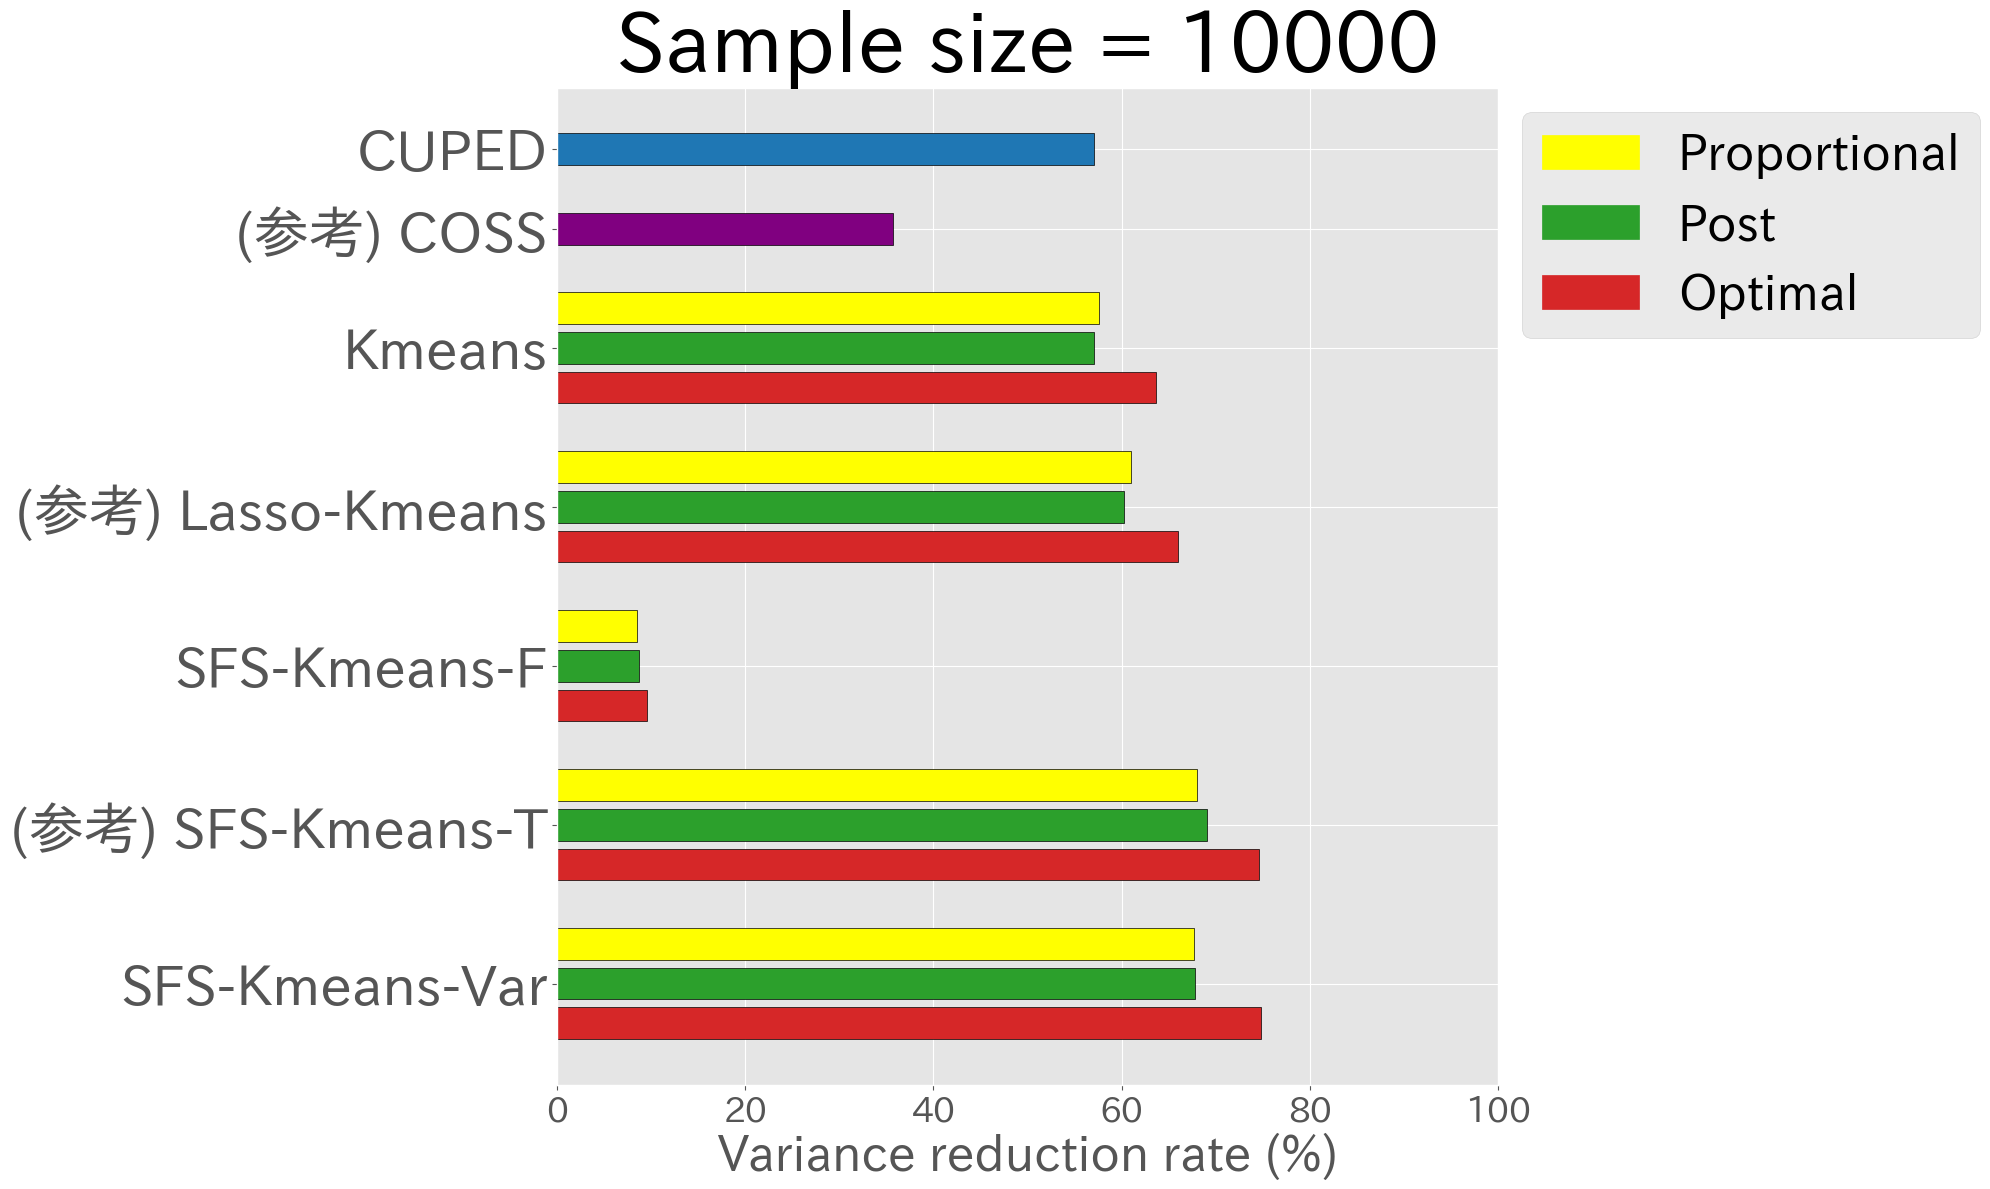

テストデータの結果


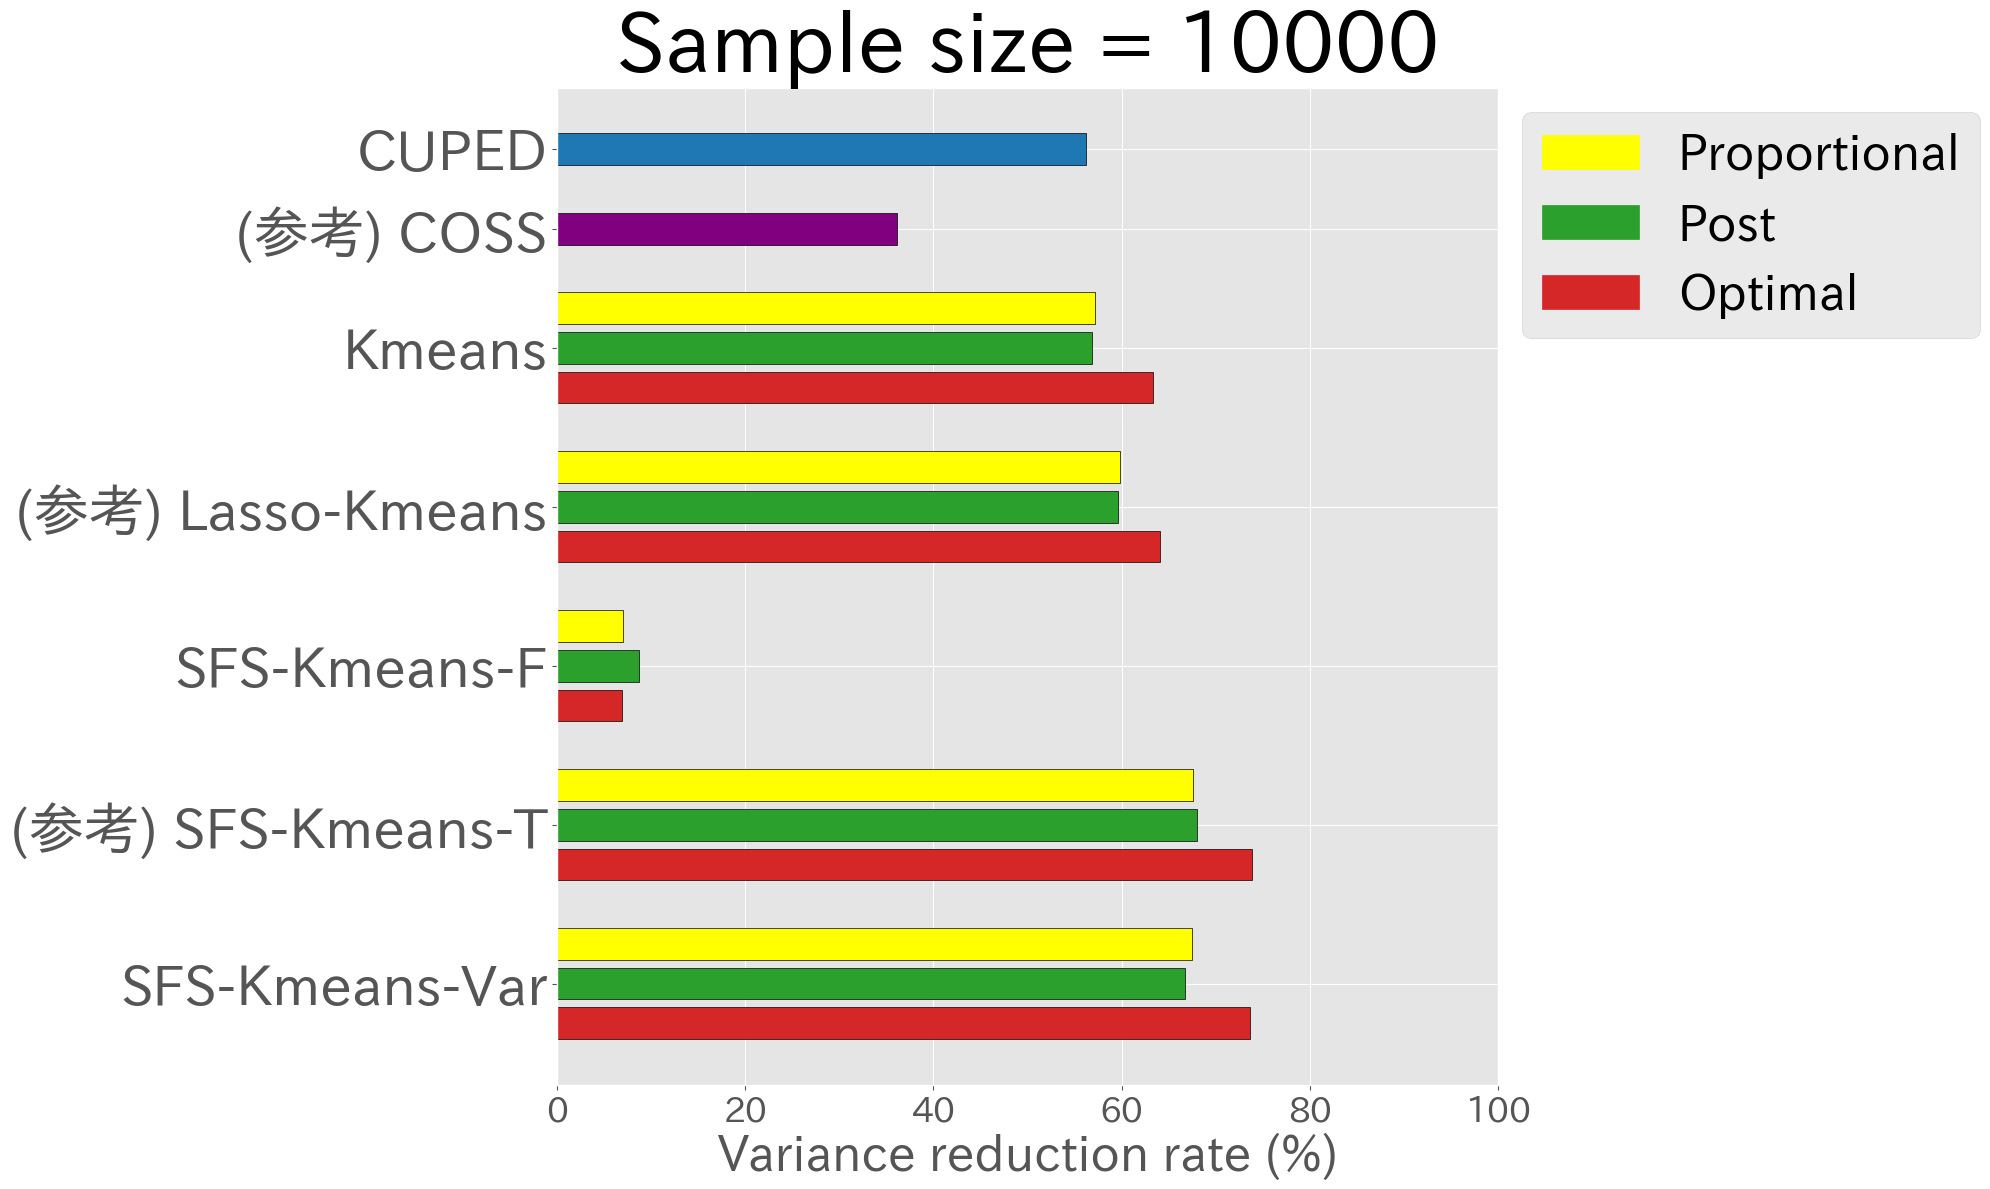

In [8]:
for reduc_dict in [reduc_dict_train, reduc_dict_test]:
    if reduc_dict == reduc_dict_train:
        print("訓練データの結果")
    if reduc_dict == reduc_dict_test:
        print("テストデータの結果")

    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-Var",
        "(参考) SFS-Kmeans-T",
        "SFS-Kmeans-F",
        "(参考) Lasso-Kmeans",
        "Kmeans",
        "(参考) COSS",
        "CUPED",
    ]
    values = (
        list(reduc_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-T"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(reduc_dict["Lasso-Kmeans"].values())
        + [0]
        + list(reduc_dict["Kmeans"].values())
        + [0]
        + [reduc_dict["COSS"]]
        + [0]
        + [reduc_dict["CUPED"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#800080"]
        + ["#FFFFFF00"]
        + ["#1f77b4"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [1, 5, 9, 13, 17, 20, 22]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Post", "Optimal"]
    # 色のリスト
    legend_colors = ["#FFFF00", "#2ca02c", "#d62728"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance reduction rate (%)", fontsize=35)
    ax.set_title(f"Sample size = {SAMPLE_SIZE}", fontsize=60)
    ax.set_xlim(0, X_LIM_REDUC)
    plt.tight_layout()
    plt.show()

### 箱ひげ図